In [72]:
cd(expanduser("/project/GHIST-2025/growth"))
Base.init_active_project()
pwd(), Base.active_project(), gethostname()

("/project/GHIST-2025/growth", "/project/GHIST-2025/growth/Project.toml", "folsomprisonblues.molgen.mpg.de")

In [73]:
using CSV
using DataFrames
using HistogramBinnings, StatsBase
using PyPlot
using HetDister, DemoPlots
using MariuxUtils, ProgressMeter, Distributed, Cached
using Serialization

In [74]:
df = CSV.read("GHIST_2025_growth.final.vcf.gz", DataFrame, comment = "##", drop = [:INFO])
first(df, 5)

Row,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,FORMAT,AFR_1,AFR_2,AFR_3,AFR_4,AFR_5,AFR_6,AFR_7,AFR_8,AFR_9,AFR_10,AFR_11,AFR_12,AFR_13,AFR_14,AFR_15,AFR_16,AFR_17,AFR_18,AFR_19,AFR_20,AFR_21,AFR_22,AFR_23,AFR_24,AFR_25,AFR_26,AFR_27,AFR_28,AFR_29,AFR_30,AFR_31,AFR_32
,String3,Int64,Int64,String1,String7,String1,String7,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3
1,2L,175,0,G,C,.,PASS,GT,0|1,0|1,1|1,0|1,1|1,0|1,1|0,1|0,1|0,1|0,1|1,1|0,1|0,0|0,0|1,0|1,1|0,0|1,0|1,1|0,0|0,1|0,1|1,1|1,0|0,0|1,1|1,1|0,1|0,0|1,0|0,0|1
2,2L,385,1,C,T,.,PASS,GT,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
3,2L,959,2,T,G,.,PASS,GT,0|1,0|1,1|1,0|1,1|1,0|1,1|0,1|0,1|0,1|0,1|1,1|0,1|0,0|0,0|1,0|1,1|0,0|1,0|1,1|0,0|0,1|0,1|1,1|1,0|0,0|1,1|1,1|0,1|0,0|1,0|0,0|1
4,2L,1050,3,A,T,.,PASS,GT,0|0,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
5,2L,1677,4,C,T,.,PASS,GT,0|1,0|1,1|1,0|1,1|1,0|1,1|0,1|0,1|0,1|0,1|1,1|0,1|0,0|0,0|1,0|1,1|0,0|1,0|1,1|0,0|0,1|0,1|1,1|1,0|0,0|1,1|1,1|0,1|0,0|1,0|0,0|1


In [75]:
@assert all(df.POS[2:end] .!= df.POS[1:end-1])

In [76]:
function getsegments(df, indv1, indv2, allele1, allele2)
    pos = [0]
    for r in eachrow(df)
        a1 = allele1 == 1 ? r[indv1][1] : r[indv1][3]
        a2 = allele2 == 1 ? r[indv2][1] : r[indv2][3]
        @assert a1 != '.' && a1 != '|'
        @assert a2 != '.' && a2 != '|'
        if a1 != a2
            push!(pos, r.POS)
        end
    end
    push!(pos, 108_990_206)
    ils = pos[2:end] .- pos[1:end-1]
end

getsegments (generic function with 1 method)

In [77]:
function aggsegs(df; nsamples=32)
    segs = Int[]
    for i in 1:(2nsamples-1)
        for j in i+1:2nsamples
            indv1 = "AFR_$((i+1)÷2)"
            indv2 = "AFR_$((j+1)÷2)"
            a1 = isodd(i) ? 1 : 2
            a2 = isodd(j) ? 1 : 2
            @assert indv1 != indv2 || a1 != a2
            ils = getsegments(df, indv1, indv2, a1, a2)
            if length(ils) == 0
                @error "No segments for $indv1($a1) and $indv2($a2), skipping."
                continue
            end
            append!(segs, ils)
        end
    end
    segs
end

aggsegs (generic function with 1 method)

In [78]:
function get_rho(chrs, path)
    rho = 0
    for chr in chrs
        genmap = CSV.read(path*chr*".txt", DataFrame)
        for i in 2:length(genmap[:, "Position(bp)"])
            locr = genmap[i, "Rate(cM/Mb)"]
            int = genmap[i, "Position(bp)"] - genmap[i-1, "Position(bp)"]
            rho += locr * int
        end
    end
    return rho / 108_990_206
end

get_rho (generic function with 1 method)

## aggregate

In [ ]:
segments = aggsegs(df);

In [ ]:
# serialize("aggregate-segments-final", segments);
# segments = deserialize("aggregate-segments");

In [ ]:
segments = segments[segments .> 0];

In [ ]:
mu = 3.36e-8
L = sum(segments)

358004801107

In [ ]:
chrs = ["2L", "2R", "3L", "3R", "X"]
path = "comeron2012v2_maps/genetic_map_comeron2012v2_dm6_chr"
rho = inv(get_rho(chrs, path) * 1e6 * 1e2)

3.925916734729728e-9

In [ ]:
hagg = adapt_histogram(segments; nbins=1700, tailthr=2);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


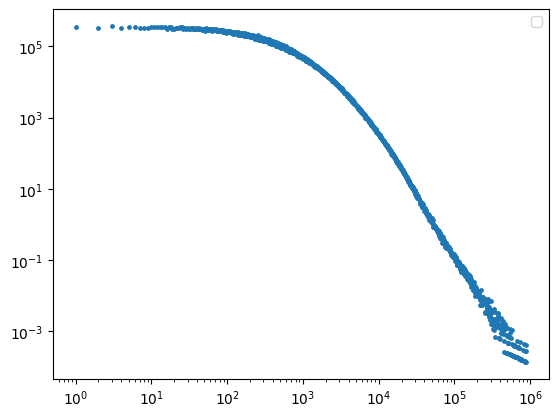

In [ ]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

x, y = xy(hagg)
ax.scatter(x, y; s = 6)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

In [ ]:
fop = FitOptions(L, mu, rho; maxnts=5, iterations=30000, time_limit=120, g_tol=1e-5)
naive = pre_fit!(fop, hagg, 6; require_convergence=false)

6-element Vector{FitResult}:
 Fit stationary (binned 1700) L-BFGS ● [1.8e+11, 8376.3] logL -1651775.671 | evidence -1651802.117
 Fit 2 epochs (binned 1700) L-BFGS ● [2.0e+11, 7330.7, 1705.1, 27817.8] logL -379574.348 | evidence -379627.338
 Fit 3 epochs (binned 1700) L-BFGS ● [2.0e+11, 10845.3, 29217.0, 6515.7, 2810.6, 19148.8] logL -167078.831 | evidence -167159.010
 Fit 4 epochs (binned 1700) L-BFGS ● [2.0e+11, 10682.3, 27350.1, 6449.8, 2241.4, 13102.2, 1129.9, 25359.4] logL -165998.893 | evidence -166102.823
 Fit 5 epochs (binned 1700) L-BFGS ● [2.0e+11, 11635.0, 25973.2, 8588.7, 20386.7, 6352.0, 2416.2, 11453.7, 1349.4, 24647.2] logL -165775.641 | evidence -165900.277
 Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10.0, 38508.1, 100000000.0, 57480.4, 9028.5, 21167.9, 6350.0, 2423.8, 11389.6, 1359.0, 24615.3] logL -165717.692 | evidence -165848.444

In [ ]:
cutoff = 1e-5
o = findfirst(map(i->HetDister.fraction(mu,rho,i),1:30) .< cutoff)

7

In [ ]:
job = (; hagg.edges, hagg.weights, L, mu, rho)

In [ ]:
fem = FlexElasticManager(threads = 64, runtime = "3h", memory = "60G") # 72 min

FlexElasticManager: AKI-Sun-2037 active: 0

In [ ]:
MariuxUtils.@everywhere fem begin

    using HetDister, StatsBase, Cached

    function fit(job)
        h = Histogram(job.edges)
        h.weights .= job.weights
        fop = FitOptions(job.L, job.mu, job.rho; order = 10, ndt = 1700, 
            maxnts=5, iterations=30000, time_limit=120, g_tol=1e-5
        )
        fit = demoinfer(h, 4:7, fop; iters = 30, corcut = 0)
        return fit
    end

end # everywhere

In [ ]:
addprocs(fem, MXQ, 1)

FlexElasticManager: AKI-Sun-2037 active: 0  MXQgroup (3h): no active jobs

In [ ]:
waituntilactive(fem)

FlexElasticManager: AKI-Sun-2037 active: 1  MXQgroup (3h): inq:0 run:1 fin:0

In [ ]:
results = pmap(fit, [job]);

In [ ]:
# serialize("results-final", results)

In [ ]:
rmprocs(fem)

FlexElasticManager: AKI-Sun-2037 active: 0, terminated: 1  MXQgroup (3h): inq:0 run:1 fin:0

In [ ]:
results[1].fits

4-element Vector{FitResult}:
 Fit 4 epochs (binned 1700) L-BFGS ● [2.0e+11, 9654.1, 27321.0, 5869.5, 2357.4, 7127.8, 1402.0, 23278.0] logL -175432.773 | evidence -175536.665
 Fit 5 epochs (binned 1700) L-BFGS ● [2.0e+11, 9621.2, 26331.0, 5855.3, 2923.2, 6683.9, 1377.8, 21202.8, 166.2, 38519.9] logL -175363.429 | evidence -175489.376
 Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10249.9, 23965.0, 6594.0, 7052.3, 5317.5, 6744.0, 6352.2, 1437.1, 20436.1, 203.2, 35837.7] logL -175257.359 | evidence -175403.574
 Fit 7 epochs (binned 1700) L-BFGS ○ [2.0e+11, 10254.4, 27402.8, 6553.1, 16.9, 82.1, 10068.3, 6268.7, 1021.2, 17010.1, 618.3, 23112.6, 115.0, 44158.3] logL -175249.982 | evidence -175410.571

In [ ]:
f = compare_models(results[1].fits)

Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10249.9, 23965.0, 6594.0, 7052.3, 5317.5, 6744.0, 6352.2, 1437.1, 20436.1, 203.2, 35837.7] logL -175257.359 | evidence -175403.574

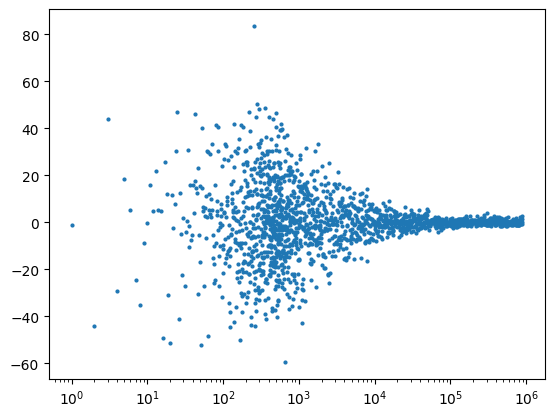

In [ ]:
_, ax = subplots(1,1)
# resid = compute_residuals(hagg, mu, rho, get_para(naive[7]), order = 20, ndt = 1700, naive=true)
wth = results[1].yth[3] .* diff(hagg.edges[1])
# wth = HetDister.integral_ws(hagg.edges[1], mu, get_para(naive[6]))
resid = (hagg.weights .- wth) ./ sqrt.(wth)
x, y = xy(hagg)
scatter(x, resid; s=4)
xscale("log")
# ylim(-0.3,0.3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


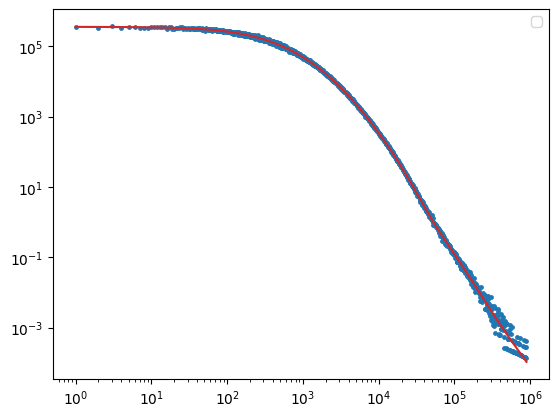

In [81]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

x, y = xy(hagg)
ax.scatter(x, y; s = 6)
ax.plot(x, results[1].yth[3], color="tab:red")

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

In [89]:
para = get_para(results[1].fits[3])
para[end] / para[end-2], sum(para[end-1:2:end-1])

(1.753640735037594, 203.17267614252222)

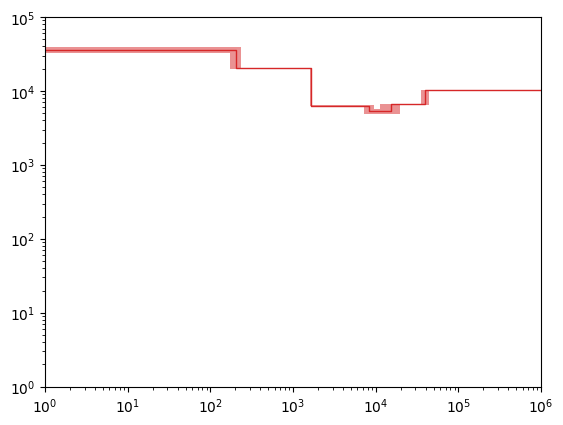

(1, 100000.0)

In [88]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

plot_demography(results[1].fits[3], ax; g = 1, rho)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 1e6)
ax.set_ylim(1, 1e5)